# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [3]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('/dogImages/dogImages/train')
valid_files, valid_targets = load_dataset('/dogImages/dogImages/valid')
test_files, test_targets = load_dataset('/dogImages/dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("/dogImages/dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [4]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


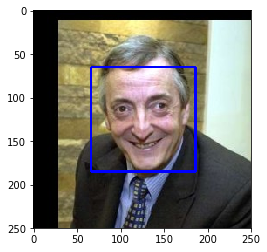

In [5]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('/harcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [6]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [7]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.
yhum = np.array([],dtype = bool)
ydog = np.array([],dtype = bool)
a=0
b=0
for i in range(len(human_files_short)):
    k = face_detector(human_files_short[i])
    #print(k)
    yhum = np.append(yhum,k)
    
for l in range(len(dog_files_short)):
    j= face_detector(dog_files_short[l])
    #print(j)
    ydog = np.append(ydog,j)

print(yhum)
print(ydog)
humpos = np.count_nonzero(yhum)
#humneg = np.count_zero(yhum)
dogpos = np.sum(ydog)
    
print("human positive " , humpos)
#print("human negative " , humpos)
print("dog positive " , dogpos)

# this is the count of dog faces that were detected as false by the human face detector which is correct since they are faces of dogs
dogneg = 100 - dogpos
    
    
## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
hacc = (humpos/100) *100
dacc = (dogneg/100) *100
print("accuracy % on human " , hacc)
print ("accuracy % on dog ",  dacc)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
[ True False False False False False False False False False False False
 False False  True  True False False False False False  True  True  True
  True False False False False False  True False  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True 

__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__
The results show that the classifier is accurate 99% of the time for humans but does not meet the same goal for dogs and is only 89% accurate it also requires that the image should be clear. This makes it less flexible for the users. Instead an algorithm which can first detect the important features based on human faces and then be trained on features for dogs like the large ears etc will be helpful.
Also if the algorithm first screens for main features that can clearly distinguish a human from a dog first then the whole image need not be passed thru the NN it can determine in the first output if the image is not a human.
One such algorithm that i found was MTCNN 
https://medium.com/wassa/modern-face-detection-based-on-deep-learning-using-python-and-mxnet-5e6377f22674

The MTCNN has 3 NNs in the first pass it eliminates the obviously false images that can easily be identified
The second NN uses the results of the first and eliminates more false images that are not human
The third NN uses the results from the second and refines the images and identifies positions of features.

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [2]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.
#import cv2                
#import matplotlib.pyplot as plt   
#import mxnet as mx

#%matplotlib inline  
#hfiles = np.array(glob("/lfw/*/*"))
# load color (BGR) image
#himg = cv2.imread(human_files[])
# convert BGR image to grayscale
#gray = cv2.cvtColor(himg, cv2.COLOR_BGR2GRAY)

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [8]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102359040/102853048 [============================>.] - ETA: 0s

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [9]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [10]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [11]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [15]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
yhum = np.array([],dtype = bool)
ydog = np.array([],dtype = bool)
a=0
b=0
for i in range(len(human_files_short)):
    k = dog_detector(human_files_short[i])
    #print(k)
    yhum = np.append(yhum,k)
    
for l in range(len(dog_files_short)):
    j= dog_detector(dog_files_short[l])
    #print(j)
    ydog = np.append(ydog,j)

print(yhum)
print(ydog)
humpos = np.count_nonzero(yhum)
#humneg = np.count_zero(yhum)
dogpos = np.sum(ydog)
    
print("human positive " , humpos)
#print("human negative " , humpos)
print("dog positive " , dogpos)

# this is the count of human faces that were detected as false by the dog face detector which is correct since they are faces of humans
humneg = 100 - humpos
    
    
## TODO: Test the performance of the dog face_detector algorithm 
## on the images in human_files_short and dog_files_short.
hacc = (humneg/100) *100
dacc = (dogpos/100) *100
print("accuracy % on human " , hacc)
print ("accuracy % on dog ",  dacc)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True 

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [13]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:06<00:00, 137.51it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

In [ ]:

### ANSWER - define model architecture 
### I tried other architectures and my accuracy was not consistent sometimes it was slightly greater that 1% and mostly 
###less than 1%. There were some reasons, my guess is as follows : 
# 1 try had the filter size (5,5) - this could have been too large
# 2nd try used some drop outs to avoid overfitting on the test set 
# 3rd try changed the activation functions alternatively between tanh and relu
# 4th try increased the number of filters randomly - this was not correct so i re-read the training
# 5th try attemped to add 1 fully connected layer at the end and flatter 
# 6th try finally attempted to simulate udacity model - the accuracy is good
    # In the udacity model first layer - we first add 16 Conv 2D filters 
    # 2nd layer we reduce the h , w by half while preserving the filters by using a max pooling layer. This helps with reducing overfitting the model to the test set
    # 3rd layer we increase the number of filters to 32 . This helps with identifying refined features (possibly edges , curves)
    # 4th layer we add more max pooling to keep the h , w from increasing which keeps it @ 55
    # 5th layer we add another conv 2d layer by increasing the number of filter to 64 . This may be used to identify features like ears, tail , eyes etc
    # 6th layer again we add a max pooling layer to reduce h, w which is now 27
    # 7th layer we add a Global Average Pooling which gets the average of each feature filter there by reducing into a single vector
    # 8th layer the final layer uses a softmax funtion to understand get the probability of classification of the 133 dog breeds 


In [16]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
print(type(train_tensors))
print(train_tensors.shape)
print(train_tensors[1])
model = Sequential()
model.add(Conv2D(16, kernel_size=(2, 2),strides=(1, 1), activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(32, (2,2),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (2,2),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Flatten())
#odel.add(Dense(1000, activation='relu'))
model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation='softmax'))

### TODO: Define your architecture. - in the above cell

model.summary()

<class 'numpy.ndarray'>
(6680, 224, 224, 3)
[[[ 0.63137257  0.38431373  0.01960784]
  [ 0.63529414  0.3882353   0.02352941]
  [ 0.63137257  0.38431373  0.01176471]
  ..., 
  [ 0.47450981  0.08627451  0.00392157]
  [ 0.44705883  0.08627451  0.        ]
  [ 0.47058824  0.10980392  0.01960784]]

 [[ 0.63529414  0.3882353   0.02352941]
  [ 0.63137257  0.38431373  0.01960784]
  [ 0.63921571  0.39215687  0.01960784]
  ..., 
  [ 0.48627451  0.09019608  0.01176471]
  [ 0.4509804   0.08235294  0.        ]
  [ 0.47450981  0.10588235  0.00784314]]

 [[ 0.63529414  0.3882353   0.02352941]
  [ 0.627451    0.38039216  0.01568628]
  [ 0.64313728  0.39607844  0.02352941]
  ..., 
  [ 0.48627451  0.09019608  0.01176471]
  [ 0.44313726  0.06666667  0.        ]
  [ 0.4627451   0.08627451  0.        ]]

 ..., 
 [[ 0.21176471  0.10980392  0.05098039]
  [ 0.21568628  0.11372549  0.05490196]
  [ 0.19607843  0.10588235  0.04313726]
  ..., 
  [ 0.21568628  0.10588235  0.10196079]
  [ 0.23921569  0.11372549  0.0

### Compile the Model

In [17]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [18]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 10

### Do NOT modify the code below this line.

#checkpointer = ModelCheckpoint(filepath='/saved_models/weights.best.from_scratch.hdf5', 
#                               verbose=1, save_best_only=True)
checkpointer = ModelCheckpoint(filepath='/output/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)
model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 21s - loss: 4.8825 - acc: 0.0102 - val_loss: 4.8693 - val_acc: 0.0084
Epoch 2/10
6680/6680 [==============================] - 20s - loss: 4.8672 - acc: 0.0118 - val_loss: 4.8544 - val_acc: 0.0168
Epoch 3/10
6680/6680 [==============================] - 21s - loss: 4.8417 - acc: 0.0157 - val_loss: 4.8209 - val_acc: 0.0156
Epoch 4/10
6680/6680 [==============================] - 21s - loss: 4.7963 - acc: 0.0198 - val_loss: 4.7853 - val_acc: 0.0180
Epoch 5/10
6680/6680 [==============================] - 20s - loss: 4.7545 - acc: 0.0205 - val_loss: 4.7691 - val_acc: 0.0275
Epoch 6/10
6680/6680 [==============================] - 21s - loss: 4.7277 - acc: 0.0226 - val_loss: 4.7523 - val_acc: 0.0132
Epoch 7/10
6680/6680 [==============================] - 21s - loss: 4.7056 - acc: 0.0284 - val_loss: 4.7427 - val_acc: 0.0180
Epoch 8/10
6680/6680 [==============================] - 20s - loss: 4.6

### Load the Model with the Best Validation Loss

In [19]:
model.load_weights('/output/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [20]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 2.9904%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [21]:
bottleneck_features = np.load('/bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [22]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [23]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [24]:
checkpointer = ModelCheckpoint(filepath='/output/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s - loss: 12.3231 - acc: 0.1316 - val_loss: 10.8412 - val_acc: 0.2168
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 10.4182 - acc: 0.2750 - val_loss: 10.2287 - val_acc: 0.2790
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 9.8925 - acc: 0.3293 - val_loss: 9.7904 - val_acc: 0.3305
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 9.5096 - acc: 0.3710 - val_loss: 9.7566 - val_acc: 0.3353
Epoch 5/20
6680/6680 [==============================] - 1s - loss: 9.3696 - acc: 0.3879 - val_loss: 9.6360 - val_acc: 0.3329
Epoch 6/20
6680/6680 [==============================] - 1s - loss: 9.1852 - acc: 0.4043 - val_loss: 9.4530 - val_acc: 0.3593
Epoch 7/20
6680/6680 [==============================] - 1s - loss: 9.0608 - acc: 0.4154 - val_loss: 9.3913 - val_acc: 0.3473
Epoch 8/20
6680/6680 [==============================] - 1s - loss: 8.8708 

### Load the Model with the Best Validation Loss

In [25]:
VGG16_model.load_weights('/output/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [26]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 41.0287%


### Predict Dog Breed with the Model

In [27]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [28]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('/bottleneck_features/DogVGG19Data.npz')
train_VGG19 = bottleneck_features['train']
valid_VGG19 = bottleneck_features['valid']
test_VGG19 = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 



In [180]:
### TODO: Define your architecture.
VGG19_model = Sequential()
print(train_VGG19.shape)
print(train_VGG19.shape[1:])
#VGG19_model.add(Dense(1000, activation ='relu',input_shape=train_VGG19.shape[1:]))
#VGG19_model.add(Conv2D(128, kernel_size=(2, 2),strides=(1, 1), activation='relu', input_shape=train_VGG19.shape[1:]))
#VGG19_model.add(MaxPooling2D(pool_size=(2, 2)))
#VGG19_model.add(Dropout(0.3))
#VGG19_model.add(Conv2D(256, (2,2),activation='relu'))
#VGG19_model.add(Conv2D(128, kernel_size=(2,2),activation='relu'))
#VGG19_model.add(MaxPooling2D(pool_size=(2, 2)))
#VGG19_model.add(Dropout(0.5))
#VGG19_model.add(Conv2D(512, kernel_size=(2,2),activation='relu'))
#VGG19_model.add(MaxPooling2D(pool_size=(2, 2)))
#VGG19_model.add(Dropout(0.5))
#VGG19_model.add(Conv2D(1024, kernel_size=(2,2),activation='relu'))
#VGG19_model.add(Dropout(0.2))
#VGG19_model.add(GlobalAveragePooling2D())
#VGG19_model.add(GlobalAveragePooling2D(input_shape=train_VGG19.shape[1:]))
#VGG19_model.add(Dense(1000, activation ='tanh'))
#VGG19_model.add(Dropout(0.3))

#VGG19_model.add(Dropout(0.2))

VGG19_model.add(GlobalAveragePooling2D(input_shape=train_VGG19.shape[1:]))
VGG19_model.add(Dense(133, activation='softmax'))

VGG19_model.summary()


(6680, 7, 7, 512)
(7, 7, 512)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_25  (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [182]:
### TODO: Compile the model.
from keras import optimizers
VGG19_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#VGG19_model.compile(loss='binary_crossentropy', optimizer = optimizers.SGD(lr=1e-4, momentum=0.9),metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [183]:
### TODO: Train the model.
checkpointer = ModelCheckpoint(filepath='/output/weights_15.best.VGG19.hdf5', 
                               verbose=1, save_best_only=True)

VGG19_model.fit(train_VGG19, train_targets, 
          validation_data=(valid_VGG19, valid_targets),
          epochs=1000, batch_size=30, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/1000
6680/6680 [==============================] - 3s - loss: 12.5476 - acc: 0.1154 - val_loss: 11.2131 - val_acc: 0.1749
Epoch 2/1000
6680/6680 [==============================] - 1s - loss: 10.2974 - acc: 0.2621 - val_loss: 10.1388 - val_acc: 0.2671
Epoch 3/1000
6680/6680 [==============================] - 1s - loss: 9.7220 - acc: 0.3362 - val_loss: 9.9718 - val_acc: 0.2934
Epoch 4/1000
6680/6680 [==============================] - 1s - loss: 9.5094 - acc: 0.3680 - val_loss: 9.7706 - val_acc: 0.3222
Epoch 5/1000
6680/6680 [==============================] - 1s - loss: 9.3419 - acc: 0.3882 - val_loss: 9.6276 - val_acc: 0.3377
Epoch 6/1000
6680/6680 [==============================] - 1s - loss: 9.1989 - acc: 0.4069 - val_loss: 9.5637 - val_acc: 0.3377
Epoch 7/1000
6680/6680 [==============================] - 1s - loss: 9.1503 - acc: 0.4162 - val_loss: 9.5711 - val_acc: 0.3425
Epoch 8/1000
6680/6680 [==============================] - 1s

6680/6680 [==============================] - 1s - loss: 7.6853 - acc: 0.5198 - val_loss: 8.4255 - val_acc: 0.4132
Epoch 29/1000
6680/6680 [==============================] - 1s - loss: 7.6141 - acc: 0.5223 - val_loss: 8.3904 - val_acc: 0.4132
Epoch 30/1000
6680/6680 [==============================] - 1s - loss: 7.5372 - acc: 0.5295 - val_loss: 8.2995 - val_acc: 0.4216
Epoch 31/1000
6680/6680 [==============================] - 1s - loss: 7.5337 - acc: 0.5301 - val_loss: 8.3387 - val_acc: 0.4192
Epoch 32/1000
6680/6680 [==============================] - 1s - loss: 7.5273 - acc: 0.5314 - val_loss: 8.3033 - val_acc: 0.4323
Epoch 33/1000
6680/6680 [==============================] - 1s - loss: 7.5169 - acc: 0.5307 - val_loss: 8.2831 - val_acc: 0.4263
Epoch 34/1000
6680/6680 [==============================] - 1s - loss: 7.4201 - acc: 0.5355 - val_loss: 8.1939 - val_acc: 0.4311
Epoch 35/1000
6680/6680 [==============================] - 1s - loss: 7.3959 - acc: 0.5398 - val_loss: 8.1749 - val_ac

6680/6680 [==============================] - 1s - loss: 6.2532 - acc: 0.6036 - val_loss: 7.3517 - val_acc: 0.4778
Epoch 58/1000
6680/6680 [==============================] - 1s - loss: 6.1746 - acc: 0.6103 - val_loss: 7.2615 - val_acc: 0.4778
Epoch 59/1000
6680/6680 [==============================] - 1s - loss: 6.1552 - acc: 0.6147 - val_loss: 7.1879 - val_acc: 0.4922
Epoch 60/1000
6680/6680 [==============================] - 1s - loss: 6.1403 - acc: 0.6169 - val_loss: 7.1833 - val_acc: 0.4874
Epoch 61/1000
6680/6680 [==============================] - 1s - loss: 6.1300 - acc: 0.6181 - val_loss: 7.2444 - val_acc: 0.4874
Epoch 62/1000
6680/6680 [==============================] - 1s - loss: 6.1246 - acc: 0.6187 - val_loss: 7.1803 - val_acc: 0.4862
Epoch 63/1000
6680/6680 [==============================] - 1s - loss: 6.1207 - acc: 0.6198 - val_loss: 7.2370 - val_acc: 0.4826
Epoch 64/1000
6680/6680 [==============================] - 1s - loss: 6.1199 - acc: 0.6195 - val_loss: 7.2088 - val_ac

6680/6680 [==============================] - 1s - loss: 5.9574 - acc: 0.6251 - val_loss: 7.1710 - val_acc: 0.4850
Epoch 90/1000
6680/6680 [==============================] - 1s - loss: 5.8180 - acc: 0.6326 - val_loss: 7.1554 - val_acc: 0.4874
Epoch 91/1000
6680/6680 [==============================] - 1s - loss: 5.7681 - acc: 0.6376 - val_loss: 7.0085 - val_acc: 0.4946
Epoch 92/1000
6680/6680 [==============================] - 1s - loss: 5.7545 - acc: 0.6407 - val_loss: 7.0288 - val_acc: 0.4886
Epoch 93/1000
6680/6680 [==============================] - 1s - loss: 5.7492 - acc: 0.6416 - val_loss: 7.0941 - val_acc: 0.4910
Epoch 94/1000
6680/6680 [==============================] - 1s - loss: 5.7453 - acc: 0.6419 - val_loss: 6.9983 - val_acc: 0.5018
Epoch 95/1000
6680/6680 [==============================] - 1s - loss: 5.7377 - acc: 0.6425 - val_loss: 7.0459 - val_acc: 0.4934
Epoch 96/1000
6680/6680 [==============================] - 1s - loss: 5.6679 - acc: 0.6443 - val_loss: 7.0512 - val_ac

6680/6680 [==============================] - 1s - loss: 5.6069 - acc: 0.6519 - val_loss: 6.9304 - val_acc: 0.5054
Epoch 121/1000
6680/6680 [==============================] - 1s - loss: 5.6069 - acc: 0.6521 - val_loss: 6.9877 - val_acc: 0.5030
Epoch 122/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9538 - val_acc: 0.4994
Epoch 123/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6519 - val_loss: 6.9373 - val_acc: 0.5030
Epoch 124/1000
6680/6680 [==============================] - 1s - loss: 5.6062 - acc: 0.6521 - val_loss: 6.9503 - val_acc: 0.4970
Epoch 125/1000
6680/6680 [==============================] - 1s - loss: 5.6055 - acc: 0.6521 - val_loss: 6.9354 - val_acc: 0.5042
Epoch 126/1000
6680/6680 [==============================] - 1s - loss: 5.6063 - acc: 0.6519 - val_loss: 6.9843 - val_acc: 0.5054
Epoch 127/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6519 - val_loss: 6.9298 -

6680/6680 [==============================] - 1s - loss: 5.6067 - acc: 0.6519 - val_loss: 6.9502 - val_acc: 0.5030
Epoch 154/1000
6680/6680 [==============================] - 1s - loss: 5.6063 - acc: 0.6521 - val_loss: 6.9574 - val_acc: 0.5042
Epoch 155/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6519 - val_loss: 6.9469 - val_acc: 0.5018
Epoch 156/1000
6680/6680 [==============================] - 1s - loss: 5.6059 - acc: 0.6521 - val_loss: 6.9480 - val_acc: 0.5042
Epoch 157/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6519 - val_loss: 6.9485 - val_acc: 0.5042
Epoch 158/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6519 - val_loss: 6.9357 - val_acc: 0.5030
Epoch 159/1000
6680/6680 [==============================] - 1s - loss: 5.6068 - acc: 0.6519 - val_loss: 6.9358 - val_acc: 0.5042
Epoch 160/1000
6680/6680 [==============================] - 1s - loss: 5.6062 - acc: 0.6521 - val_loss: 6.9794 -

6680/6680 [==============================] - 1s - loss: 5.6069 - acc: 0.6521 - val_loss: 6.9387 - val_acc: 0.5030
Epoch 187/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6519 - val_loss: 6.9318 - val_acc: 0.5030
Epoch 188/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6519 - val_loss: 6.9383 - val_acc: 0.5030
Epoch 189/1000
6680/6680 [==============================] - 1s - loss: 5.6069 - acc: 0.6519 - val_loss: 6.9383 - val_acc: 0.5030
Epoch 190/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6519 - val_loss: 6.9477 - val_acc: 0.5042
Epoch 191/1000
6680/6680 [==============================] - 1s - loss: 5.6067 - acc: 0.6519 - val_loss: 6.9591 - val_acc: 0.5042
Epoch 192/1000
6680/6680 [==============================] - 1s - loss: 5.6059 - acc: 0.6521 - val_loss: 6.9570 - val_acc: 0.5018
Epoch 193/1000
6680/6680 [==============================] - 1s - loss: 5.6067 - acc: 0.6521 - val_loss: 6.9523 -

6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9614 - val_acc: 0.5042
Epoch 220/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6521 - val_loss: 6.9616 - val_acc: 0.5030
Epoch 221/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6521 - val_loss: 6.9640 - val_acc: 0.5030
Epoch 222/1000
6680/6680 [==============================] - 1s - loss: 5.6068 - acc: 0.6521 - val_loss: 6.9647 - val_acc: 0.5030
Epoch 223/1000
6680/6680 [==============================] - 1s - loss: 5.6066 - acc: 0.6521 - val_loss: 6.9581 - val_acc: 0.5042
Epoch 224/1000
6680/6680 [==============================] - 1s - loss: 5.6074 - acc: 0.6521 - val_loss: 6.9538 - val_acc: 0.5030
Epoch 225/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6519 - val_loss: 6.9486 - val_acc: 0.5042
Epoch 226/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6521 - val_loss: 6.9357 -

6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6521 - val_loss: 6.9515 - val_acc: 0.5042
Epoch 253/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6521 - val_loss: 6.9507 - val_acc: 0.5042
Epoch 254/1000
6680/6680 [==============================] - 1s - loss: 5.6058 - acc: 0.6519 - val_loss: 6.9781 - val_acc: 0.5066
Epoch 255/1000
6680/6680 [==============================] - 1s - loss: 5.6065 - acc: 0.6521 - val_loss: 6.9439 - val_acc: 0.5042
Epoch 256/1000
6680/6680 [==============================] - 1s - loss: 5.6068 - acc: 0.6519 - val_loss: 6.9471 - val_acc: 0.5054
Epoch 257/1000
6680/6680 [==============================] - 1s - loss: 5.6061 - acc: 0.6521 - val_loss: 6.9522 - val_acc: 0.5042
Epoch 258/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6519 - val_loss: 6.9505 - val_acc: 0.5030
Epoch 259/1000
6680/6680 [==============================] - 1s - loss: 5.6067 - acc: 0.6521 - val_loss: 6.9449 -

6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9291 - val_acc: 0.5042
Epoch 286/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6521 - val_loss: 6.9565 - val_acc: 0.5018
Epoch 287/1000
6680/6680 [==============================] - 1s - loss: 5.6072 - acc: 0.6521 - val_loss: 6.9514 - val_acc: 0.5006
Epoch 288/1000
6680/6680 [==============================] - 1s - loss: 5.6069 - acc: 0.6521 - val_loss: 6.9549 - val_acc: 0.5006
Epoch 289/1000
6680/6680 [==============================] - 1s - loss: 5.6072 - acc: 0.6521 - val_loss: 6.9585 - val_acc: 0.5018
Epoch 290/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9582 - val_acc: 0.5030
Epoch 291/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6521 - val_loss: 6.9603 - val_acc: 0.5006
Epoch 292/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9622 -

6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9410 - val_acc: 0.5078
Epoch 319/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9413 - val_acc: 0.5078
Epoch 320/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9428 - val_acc: 0.5090
Epoch 321/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9442 - val_acc: 0.5090
Epoch 322/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6521 - val_loss: 6.9431 - val_acc: 0.5078
Epoch 323/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6521 - val_loss: 6.9479 - val_acc: 0.5078
Epoch 324/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9500 - val_acc: 0.5102
Epoch 325/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6521 - val_loss: 6.9521 -

6680/6680 [==============================] - 1s - loss: 5.6072 - acc: 0.6521 - val_loss: 6.9563 - val_acc: 0.5054
Epoch 352/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6521 - val_loss: 6.9624 - val_acc: 0.5054
Epoch 353/1000
6680/6680 [==============================] - 1s - loss: 5.6068 - acc: 0.6521 - val_loss: 6.9778 - val_acc: 0.5054
Epoch 354/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9627 - val_acc: 0.5066
Epoch 355/1000
6680/6680 [==============================] - 1s - loss: 5.6072 - acc: 0.6521 - val_loss: 6.9501 - val_acc: 0.5042
Epoch 356/1000
6680/6680 [==============================] - 1s - loss: 5.6072 - acc: 0.6521 - val_loss: 6.9473 - val_acc: 0.5054
Epoch 357/1000
6680/6680 [==============================] - 1s - loss: 5.6072 - acc: 0.6521 - val_loss: 6.9493 - val_acc: 0.5090
Epoch 358/1000
6680/6680 [==============================] - 1s - loss: 5.6072 - acc: 0.6521 - val_loss: 6.9506 -

6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9730 - val_acc: 0.5078
Epoch 385/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6521 - val_loss: 6.9741 - val_acc: 0.5054
Epoch 386/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6521 - val_loss: 6.9713 - val_acc: 0.5066
Epoch 387/1000
6680/6680 [==============================] - 1s - loss: 5.6072 - acc: 0.6521 - val_loss: 6.9718 - val_acc: 0.5066
Epoch 388/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6521 - val_loss: 6.9649 - val_acc: 0.5066
Epoch 389/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6521 - val_loss: 6.9651 - val_acc: 0.5066
Epoch 390/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9717 - val_acc: 0.5066
Epoch 391/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9743 -

6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9593 - val_acc: 0.5090
Epoch 418/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6519 - val_loss: 6.9600 - val_acc: 0.5078
Epoch 419/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6519 - val_loss: 6.9606 - val_acc: 0.5078
Epoch 420/1000
6680/6680 [==============================] - 1s - loss: 5.6067 - acc: 0.6521 - val_loss: 6.9594 - val_acc: 0.5090
Epoch 421/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6519 - val_loss: 6.9580 - val_acc: 0.5090
Epoch 422/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9589 - val_acc: 0.5090
Epoch 423/1000
6680/6680 [==============================] - 1s - loss: 5.6069 - acc: 0.6521 - val_loss: 6.9567 - val_acc: 0.5078
Epoch 424/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9650 -

6680/6680 [==============================] - 1s - loss: 5.6072 - acc: 0.6521 - val_loss: 6.9602 - val_acc: 0.5078
Epoch 451/1000
6680/6680 [==============================] - 1s - loss: 5.6072 - acc: 0.6521 - val_loss: 6.9607 - val_acc: 0.5078
Epoch 452/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9557 - val_acc: 0.5042
Epoch 453/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9638 - val_acc: 0.5018
Epoch 454/1000
6680/6680 [==============================] - 1s - loss: 5.6067 - acc: 0.6521 - val_loss: 6.9619 - val_acc: 0.5054
Epoch 455/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6519 - val_loss: 6.9679 - val_acc: 0.5042
Epoch 456/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9624 - val_acc: 0.5066
Epoch 457/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9622 -

6680/6680 [==============================] - 1s - loss: 5.6072 - acc: 0.6521 - val_loss: 6.9705 - val_acc: 0.5090
Epoch 484/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9514 - val_acc: 0.5066
Epoch 485/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9497 - val_acc: 0.5102
Epoch 486/1000
6680/6680 [==============================] - 1s - loss: 5.6072 - acc: 0.6521 - val_loss: 6.9513 - val_acc: 0.5102
Epoch 487/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9512 - val_acc: 0.5102
Epoch 488/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9529 - val_acc: 0.5114
Epoch 489/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9537 - val_acc: 0.5114
Epoch 490/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9540 -

6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9536 - val_acc: 0.5102
Epoch 517/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9568 - val_acc: 0.5114
Epoch 518/1000
6680/6680 [==============================] - 1s - loss: 5.6072 - acc: 0.6521 - val_loss: 6.9605 - val_acc: 0.5102
Epoch 519/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6521 - val_loss: 6.9618 - val_acc: 0.5114
Epoch 520/1000
6680/6680 [==============================] - 1s - loss: 5.6054 - acc: 0.6521 - val_loss: 6.9571 - val_acc: 0.5102
Epoch 521/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6521 - val_loss: 6.9629 - val_acc: 0.5114
Epoch 522/1000
6680/6680 [==============================] - 1s - loss: 5.6072 - acc: 0.6521 - val_loss: 6.9631 - val_acc: 0.5102
Epoch 523/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9626 -

6680/6680 [==============================] - 1s - loss: 5.6075 - acc: 0.6521 - val_loss: 6.9828 - val_acc: 0.5018
Epoch 550/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6519 - val_loss: 6.9719 - val_acc: 0.5054
Epoch 551/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6519 - val_loss: 6.9717 - val_acc: 0.5054
Epoch 552/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6519 - val_loss: 6.9712 - val_acc: 0.5054
Epoch 553/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6519 - val_loss: 6.9712 - val_acc: 0.5054
Epoch 554/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6519 - val_loss: 6.9711 - val_acc: 0.5054
Epoch 555/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6519 - val_loss: 6.9711 - val_acc: 0.5054
Epoch 556/1000
6680/6680 [==============================] - 1s - loss: 5.6072 - acc: 0.6521 - val_loss: 6.9762 -

6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9626 - val_acc: 0.5042
Epoch 583/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9634 - val_acc: 0.5042
Epoch 584/1000
6680/6680 [==============================] - 1s - loss: 5.6072 - acc: 0.6521 - val_loss: 6.9641 - val_acc: 0.5042
Epoch 585/1000
6680/6680 [==============================] - 1s - loss: 5.6072 - acc: 0.6521 - val_loss: 6.9650 - val_acc: 0.5054
Epoch 586/1000
6680/6680 [==============================] - 1s - loss: 5.6072 - acc: 0.6521 - val_loss: 6.9653 - val_acc: 0.5054
Epoch 587/1000
6680/6680 [==============================] - 1s - loss: 5.6072 - acc: 0.6521 - val_loss: 6.9657 - val_acc: 0.5066
Epoch 588/1000
6680/6680 [==============================] - 1s - loss: 5.6072 - acc: 0.6521 - val_loss: 6.9661 - val_acc: 0.5066
Epoch 589/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9698 -

6680/6680 [==============================] - 1s - loss: 5.6073 - acc: 0.6521 - val_loss: 6.9646 - val_acc: 0.5078
Epoch 616/1000
6680/6680 [==============================] - 1s - loss: 5.6073 - acc: 0.6521 - val_loss: 6.9650 - val_acc: 0.5078
Epoch 617/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9731 - val_acc: 0.5030
Epoch 618/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9719 - val_acc: 0.5030
Epoch 619/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9725 - val_acc: 0.5030
Epoch 620/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9749 - val_acc: 0.5030
Epoch 621/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9757 - val_acc: 0.5030
Epoch 622/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9759 -

6680/6680 [==============================] - 1s - loss: 5.6064 - acc: 0.6521 - val_loss: 6.9779 - val_acc: 0.5090
Epoch 649/1000
6680/6680 [==============================] - 1s - loss: 5.6069 - acc: 0.6519 - val_loss: 6.9788 - val_acc: 0.5090
Epoch 650/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6519 - val_loss: 6.9787 - val_acc: 0.5090
Epoch 651/1000
6680/6680 [==============================] - 1s - loss: 5.6076 - acc: 0.6521 - val_loss: 6.9844 - val_acc: 0.5090
Epoch 652/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6519 - val_loss: 6.9798 - val_acc: 0.5066
Epoch 653/1000
6680/6680 [==============================] - 1s - loss: 5.6061 - acc: 0.6521 - val_loss: 6.9867 - val_acc: 0.5090
Epoch 654/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6519 - val_loss: 6.9865 - val_acc: 0.5090
Epoch 655/1000
6680/6680 [==============================] - 1s - loss: 5.6072 - acc: 0.6521 - val_loss: 6.9782 -

6680/6680 [==============================] - 1s - loss: 5.6073 - acc: 0.6521 - val_loss: 6.9673 - val_acc: 0.5078
Epoch 682/1000
6680/6680 [==============================] - 1s - loss: 5.6069 - acc: 0.6519 - val_loss: 6.9693 - val_acc: 0.5078
Epoch 683/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6519 - val_loss: 6.9696 - val_acc: 0.5078
Epoch 684/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6519 - val_loss: 6.9698 - val_acc: 0.5078
Epoch 685/1000
6680/6680 [==============================] - 1s - loss: 5.6074 - acc: 0.6521 - val_loss: 6.9649 - val_acc: 0.5090
Epoch 686/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6519 - val_loss: 6.9764 - val_acc: 0.5054
Epoch 687/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6519 - val_loss: 6.9759 - val_acc: 0.5054
Epoch 688/1000
6680/6680 [==============================] - 1s - loss: 5.6074 - acc: 0.6521 - val_loss: 6.9710 -

6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6519 - val_loss: 6.9685 - val_acc: 0.5078
Epoch 715/1000
6680/6680 [==============================] - 1s - loss: 5.6075 - acc: 0.6521 - val_loss: 6.9654 - val_acc: 0.5066
Epoch 716/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6519 - val_loss: 6.9634 - val_acc: 0.5066
Epoch 717/1000
6680/6680 [==============================] - 1s - loss: 5.6072 - acc: 0.6521 - val_loss: 6.9647 - val_acc: 0.5066
Epoch 718/1000
6680/6680 [==============================] - 1s - loss: 5.6072 - acc: 0.6521 - val_loss: 6.9653 - val_acc: 0.5066
Epoch 719/1000
6680/6680 [==============================] - 1s - loss: 5.6072 - acc: 0.6521 - val_loss: 6.9656 - val_acc: 0.5066
Epoch 720/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9660 - val_acc: 0.5066
Epoch 721/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6521 - val_loss: 6.9665 -

6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9605 - val_acc: 0.5102
Epoch 748/1000
6680/6680 [==============================] - 1s - loss: 5.6072 - acc: 0.6521 - val_loss: 6.9666 - val_acc: 0.5042
Epoch 749/1000
6680/6680 [==============================] - 1s - loss: 5.6072 - acc: 0.6521 - val_loss: 6.9640 - val_acc: 0.5042
Epoch 750/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9681 - val_acc: 0.5042
Epoch 751/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6521 - val_loss: 6.9656 - val_acc: 0.5042
Epoch 752/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9685 - val_acc: 0.5042
Epoch 753/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6521 - val_loss: 6.9682 - val_acc: 0.5042
Epoch 754/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9768 -

6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9693 - val_acc: 0.5006
Epoch 781/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6521 - val_loss: 6.9610 - val_acc: 0.4994
Epoch 782/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9603 - val_acc: 0.5006
Epoch 783/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9600 - val_acc: 0.5006
Epoch 784/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6521 - val_loss: 6.9613 - val_acc: 0.5042
Epoch 785/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6521 - val_loss: 6.9699 - val_acc: 0.5006
Epoch 786/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9700 - val_acc: 0.5006
Epoch 787/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9704 -

6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6519 - val_loss: 6.9615 - val_acc: 0.5042
Epoch 814/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6519 - val_loss: 6.9647 - val_acc: 0.5042
Epoch 815/1000
6680/6680 [==============================] - 1s - loss: 5.6074 - acc: 0.6521 - val_loss: 6.9629 - val_acc: 0.5042
Epoch 816/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6519 - val_loss: 6.9635 - val_acc: 0.5042
Epoch 817/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6519 - val_loss: 6.9676 - val_acc: 0.5054
Epoch 818/1000
6680/6680 [==============================] - 1s - loss: 5.6074 - acc: 0.6521 - val_loss: 6.9634 - val_acc: 0.5042
Epoch 819/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6519 - val_loss: 6.9640 - val_acc: 0.5042
Epoch 820/1000
6680/6680 [==============================] - 1s - loss: 5.6068 - acc: 0.6521 - val_loss: 6.9612 -

6680/6680 [==============================] - 1s - loss: 5.6072 - acc: 0.6521 - val_loss: 6.9572 - val_acc: 0.5066
Epoch 847/1000
6680/6680 [==============================] - 1s - loss: 5.6072 - acc: 0.6521 - val_loss: 6.9584 - val_acc: 0.5054
Epoch 848/1000
6680/6680 [==============================] - 1s - loss: 5.6069 - acc: 0.6519 - val_loss: 6.9580 - val_acc: 0.5054
Epoch 849/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6519 - val_loss: 6.9579 - val_acc: 0.5054
Epoch 850/1000
6680/6680 [==============================] - 1s - loss: 5.6074 - acc: 0.6521 - val_loss: 6.9579 - val_acc: 0.5054
Epoch 851/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6519 - val_loss: 6.9579 - val_acc: 0.5054
Epoch 852/1000
6680/6680 [==============================] - 1s - loss: 5.6074 - acc: 0.6521 - val_loss: 6.9598 - val_acc: 0.5054
Epoch 853/1000
6680/6680 [==============================] - 1s - loss: 5.6072 - acc: 0.6521 - val_loss: 6.9612 -

6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6521 - val_loss: 6.9504 - val_acc: 0.5054
Epoch 880/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6521 - val_loss: 6.9505 - val_acc: 0.5054
Epoch 881/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9569 - val_acc: 0.5066
Epoch 882/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6521 - val_loss: 6.9553 - val_acc: 0.5066
Epoch 883/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6521 - val_loss: 6.9554 - val_acc: 0.5066
Epoch 884/1000
6680/6680 [==============================] - 1s - loss: 5.6072 - acc: 0.6521 - val_loss: 6.9555 - val_acc: 0.5066
Epoch 885/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9589 - val_acc: 0.5054
Epoch 886/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6521 - val_loss: 6.9584 -

6680/6680 [==============================] - 1s - loss: 5.6072 - acc: 0.6521 - val_loss: 6.9667 - val_acc: 0.5030
Epoch 913/1000
6680/6680 [==============================] - 1s - loss: 5.6070 - acc: 0.6521 - val_loss: 6.9682 - val_acc: 0.5030
Epoch 914/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9683 - val_acc: 0.5030
Epoch 915/1000
6680/6680 [==============================] - 1s - loss: 5.6072 - acc: 0.6521 - val_loss: 6.9685 - val_acc: 0.5030
Epoch 916/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6521 - val_loss: 6.9502 - val_acc: 0.5006
Epoch 917/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9520 - val_acc: 0.5018
Epoch 918/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9526 - val_acc: 0.5018
Epoch 919/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9517 -

6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6521 - val_loss: 6.9511 - val_acc: 0.5006
Epoch 946/1000
6680/6680 [==============================] - 1s - loss: 5.6072 - acc: 0.6521 - val_loss: 6.9515 - val_acc: 0.5006
Epoch 947/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9504 - val_acc: 0.5006
Epoch 948/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9499 - val_acc: 0.4994
Epoch 949/1000
6680/6680 [==============================] - 1s - loss: 5.6072 - acc: 0.6521 - val_loss: 6.9509 - val_acc: 0.5006
Epoch 950/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9506 - val_acc: 0.5006
Epoch 951/1000
6680/6680 [==============================] - 1s - loss: 5.6072 - acc: 0.6521 - val_loss: 6.9509 - val_acc: 0.5006
Epoch 952/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9519 -

6680/6680 [==============================] - 1s - loss: 5.6072 - acc: 0.6521 - val_loss: 6.9524 - val_acc: 0.4970
Epoch 979/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9522 - val_acc: 0.4970
Epoch 980/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9533 - val_acc: 0.4970
Epoch 981/1000
6680/6680 [==============================] - 1s - loss: 5.6072 - acc: 0.6521 - val_loss: 6.9533 - val_acc: 0.4970
Epoch 982/1000
6680/6680 [==============================] - 1s - loss: 5.6072 - acc: 0.6521 - val_loss: 6.9529 - val_acc: 0.4970
Epoch 983/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6519 - val_loss: 6.9541 - val_acc: 0.4970
Epoch 984/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6521 - val_loss: 6.9531 - val_acc: 0.4970
Epoch 985/1000
6680/6680 [==============================] - 1s - loss: 5.6071 - acc: 0.6521 - val_loss: 6.9500 -

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [184]:
### TODO: Load the model weights with the best validation loss.
VGG19_model.load_weights('/output/weights_15.best.VGG19.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [185]:
### TODO: Calculate classification accuracy on the test dataset.
VGG19_predictions = [np.argmax(VGG19_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG19]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG19_predictions)==np.argmax(test_targets, axis=1))/len(VGG19_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 50.7177%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [186]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
from keras.preprocessing import image
from extract_bottleneck_features import *
#img_disp = np.array(glob('/dogImages/dogImages/valid/040.Bulldog/Bulldog_02857.jpg'))
#print(img_disp)
#myimg = cv2.imread(img_disp[0])
#imggray = cv2.cvtColor(myimg, cv2.COLOR_BGR2GRAY)
#print(imggray)
#img_disp = cv2.cvtColor(img_disp, cv2.COLOR_BGR2GRAY)

#plt.imshow(img_disp)
#myimg = image.load_img('/dogImages/valid/040.Bulldog/Bulldog_02857.jpg')


def VGG19_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG19(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG19_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [187]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
myimg_path = input('Path to your image')
#myimg_path = '/dogImages/dogImages/valid/040.Bulldog/Bulldog_02857.jpg'
isithuman= face_detector(myimg_path)
print(isithuman)
isitdog = dog_detector(myimg_path)
print(isitdog)
if isithuman == True :
   # predbreed = VGG19_predict_breed(myimg_path)
    VGG19_predict_breed(myimg_path)
    #print(isinstance(predbreed))
    print(" Hi Human you resemble ",VGG19_predict_breed(myimg_path))
if isitdog == True :
   # predbreed = VGG19_predict_breed(myimg_path)
    VGG19_predict_breed(myimg_path)
    #print(isinstance(predbreed))
    print(" BowBow you resemble ",VGG19_predict_breed(myimg_path))
    

Path to your image/dogImages/dogImages/valid/040.Bulldog/Bulldog_02857.jpg
False
True
 BowBow you resemble  /train/040.Bulldog


---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

In [188]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
import os
myfold = '/harcascades/myimage'
listing = os.listdir(myfold)
for filenames in listing:
   # for f in filenames:
    #myfile= os.path.join(root, f)
    print('/harcascades/myimage/'+filenames)  
    if filenames.endswith('.jpg') or filenames.endswith('.PNG') :
        #VGG19_predict_breed('/harcascades/myimage/'+filenames)
        print("Dog Breed is : ", VGG19_predict_breed('/harcascades/myimage/'+filenames))

    

/harcascades/myimage/grumpy cat.PNG
Dog Breed is :  /train/123.Pomeranian
/harcascades/myimage/sidd.PNG
Dog Breed is :  /train/049.Chinese_crested
/harcascades/myimage/catsunglaaes.jpg
Dog Breed is :  /train/048.Chihuahua
/harcascades/myimage/saha.PNG
Dog Breed is :  /train/122.Pointer
/harcascades/myimage/pexels-photo-191340.jpeg
/harcascades/myimage/dog2.PNG
Dog Breed is :  /train/120.Pharaoh_hound
/harcascades/myimage/dog-photo-58997.jpeg
/harcascades/myimage/flower.PNG
Dog Breed is :  /train/069.French_bulldog
/harcascades/myimage/doghorse.jpg
Dog Breed is :  /train/002.Afghan_hound
/harcascades/myimage/dog.PNG
Dog Breed is :  /train/096.Labrador_retriever
/harcascades/myimage/catglass.PNG
Dog Breed is :  /train/084.Icelandic_sheepdog
/harcascades/myimage/ferdinandbull.PNG
Dog Breed is :  /train/078.Great_dane
/harcascades/myimage/human1.jpg
Dog Breed is :  /train/124.Poodle
/harcascades/myimage/cat.PNG
Dog Breed is :  /train/017.Bearded_collie
/harcascades/myimage/human2.jpg
Dog B

In [ ]:
I think my output is better (compared to the previous runs). The algorithm can benefit 
1. Augmented training set
2. Rescale images
3. Train on more images